# Proyek Klasifikasi Gambar: Klasifikasi Bunga dengan CNN
- **Nama:** Gibran Daffa Atallah
- **Email:** gibrandaffa92@gmail.com
- **ID Dicoding:** gibrandaffa

## Import Semua Packages/Library yang Digunakan

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers, models
from keras.callbacks import Callback, EarlyStopping

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# colab
from google.colab import drive
import zipfile

## Data Preparation

### Moving Data

Karena saya menggunakan Google Colab, maka saya akan mengambil dataset dari Google Drive.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir model-datasets

In [ ]:
!cp drive/MyDrive/model-datasets.zip .

In [ ]:
zipfile.ZipFile('model-datasets.zip', 'r').extractall('model-datasets')

In [ ]:
!rm model-datasets.zip

### Data Loading

In [ ]:
train_gen = ImageDataGenerator(
    rescale            = 1/255,
    horizontal_flip    = True,
    zoom_range         = 0.2,
    shear_range        = 0.2,
    rotation_range     = 10,
    width_shift_range  = 0.2,
    height_shift_range = 0.2,
)

test_gen = ImageDataGenerator(rescale=1/255)

Karena dataset sudah di-split, maka saya akan mengaksesnya berdasarkan set nya.

In [ ]:
train = train_gen.flow_from_directory(
    'model-datasets/train',
    target_size = [224, 224],
    batch_size  = 32
)

validation = test_gen.flow_from_directory(
    'model-datasets/validation',
    target_size = [224, 224],
    batch_size  = 32
)

test = test_gen.flow_from_directory(
    'model-datasets/test',
    target_size = [224, 224],
    batch_size  = 32,
    shuffle      = False
)

Found 1311 images belonging to 5 classes.
Found 165 images belonging to 5 classes.
Found 162 images belonging to 5 classes.


### Data Preprocessing

#### Split Dataset

Split dataset telah dilakukan secara eksplisit oleh script `scripts/split-dataset.py`. Ini dilakukan untuk konsistensi dataset yang digunakan pada pelatihan, validasi, dan pengujian yang mempermudah parameter tuning.

## Modelling

### Model

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, [3, 3], activation='relu', input_shape=[224, 224, 3]),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, [3, 3], activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, [3, 3], activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(256, [3, 3], activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.55),
    layers.Dense(5, activation='softmax')
])

In [ ]:
model.compile(
    optimizer ='adam',
    loss      = 'categorical_crossentropy',
    metrics   = ['accuracy']
)

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       9,437,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,827,141 (37.49 MB)

 Trainable params: 9,827,141 (37.49 MB)

 Non-trainable params: 0 (0.00 B)

### Callback

In [ ]:
class CallbackStop(Callback):
    def on_epoch_end(self, epoch, logs):
        if (logs.get('accuracy') >= 0.96):
            print('✅ Akursasi sudah diatas 96%')
            self.model.stop_training = True

In [ ]:
callback_stop  = CallbackStop()
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, mode='min')

### Training

In [ ]:
history = model.fit(train, epochs=80, validation_data=validation, callbacks=[callback_stop, early_stopping])

Epoch 1/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 470ms/step - accuracy: 0.2407 - loss: 1.8013 - val_accuracy: 0.4970 - val_loss: 1.1935
Epoch 2/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 37s 419ms/step - accuracy: 0.5171 - loss: 1.1481 - val_accuracy: 0.6970 - val_loss: 1.0016
Epoch 3/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 440ms/step - accuracy: 0.5931 - loss: 1.0381 - val_accuracy: 0.5939 - val_loss: 1.0699
Epoch 4/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 412ms/step - accuracy: 0.6022 - loss: 1.0147 - val_accuracy: 0.7152 - val_loss: 0.8238
Epoch 5/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 411ms/step - accuracy: 0.7349 - loss: 0.7493 - val_accuracy: 0.7212 - val_loss: 0.7592
Epoch 6/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 447ms/step - accuracy: 0.7488 - loss: 0.7412 - val_accuracy: 0.7455 - val_loss: 0.6802
Epoch 7/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 415ms/step - accuracy: 0.8026 - loss: 0.5978 - val_accuracy: 0.7879 - val_loss: 0.7032
Epoch 8/80
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 415ms/step - accuracy: 0.7801 - loss: 0.6553 - val_accu

## Evaluasi dan Visualisasi

### Evaluasi

In [ ]:
def evaluate(name, dataset):
    print(f'🔵 {name}')
    loss, acc = model.evaluate(dataset)
    print(f'{name} loss: {loss}')
    print(f'{name} accuracy: {acc}')

In [ ]:
evaluate('train', train)

🔵 train
41/41 ━━━━━━━━━━━━━━━━━━━━ 115s 112ms/step - accuracy: 0.9712 - loss: 0.0651
train loss: 0.06271953135728836
train accuracy: 0.972540020942688


In [ ]:
evaluate('validation', validation)

🔵 validation
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.9210 - loss: 0.3383
validation loss: 0.34449610114097595
validation accuracy: 0.9272727370262146


In [ ]:
evaluate('test', test)

🔵 test
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9321 - loss: 0.3157
test loss: 0.33503201603889465
test accuracy: 0.9320987462997437


**Insight**:
- Akurasi pada data latih tinggi, hingga mencapai 97%. Ini membuktikan bahwa model belajar dengan baik pada data latih.
- Akurasi pada data validasi dan tes hanya mencapai 93%. Ini berarti ada beberapa data yang mungkin kurang dipelajari di dataset tersebut.

### Visualisasi

In [ ]:
def visualize(name):
    plt.figure(figsize=[15, 5])
    plt.plot(history.history[name], label='train', marker='o')
    plt.plot(history.history[f'val_{name}'], label='val', marker='o')

    plt.title(name.capitalize())
    plt.xlabel('epoch')
    plt.ylabel(name)
    plt.grid()
    plt.legend()
    plt.show()

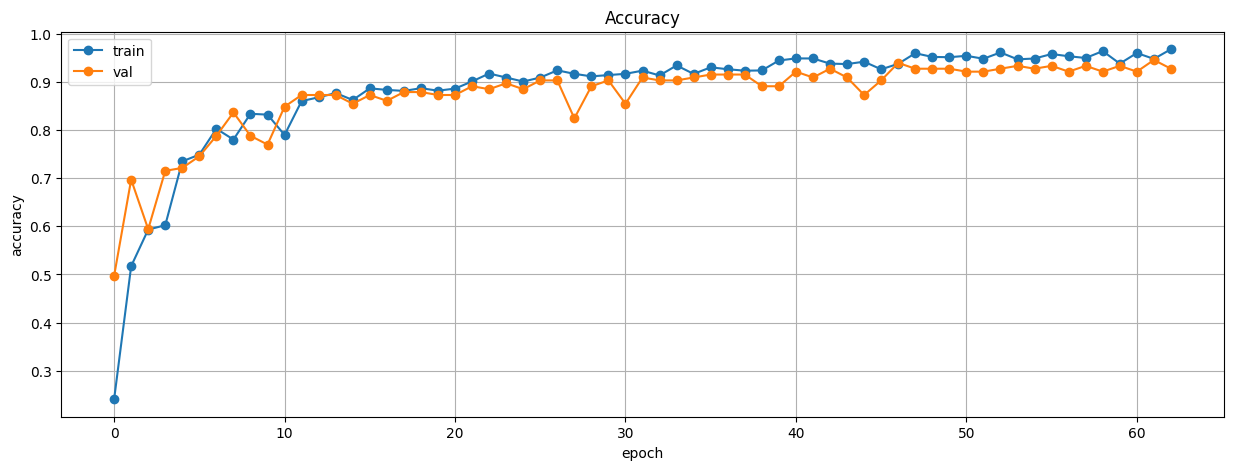

In [ ]:
visualize('accuracy')

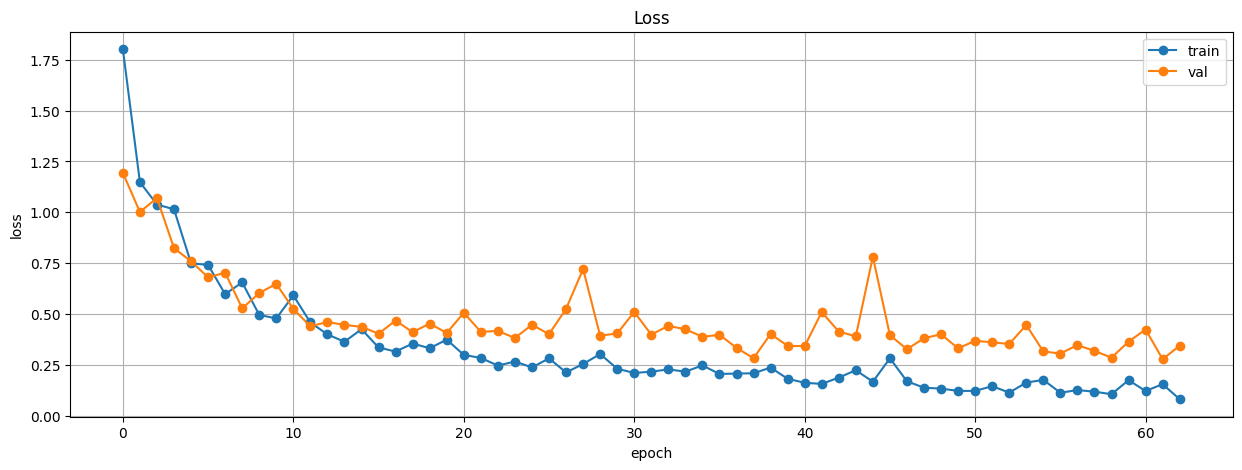

In [ ]:
visualize('loss')

**Insight**:
- Akurasi membaik semakin lama model dilatih, baik data pelatihan atau data validasi.
- Peningkatan akurasi semakin rendah semakin lama model dilatih yang mungkin mengakibatkan *diminishing return* pada data validasi dan tes.
- *Loss* membaik semakin lama model dilatih, tapi ini tidak terlalu berpengaruh pada data validasi.

## Konversi Model

In [ ]:
!mkdir models

In [ ]:
model.save('models/model.h5', include_optimizer=False)

### SavedModel

In [ ]:
!mkdir models/saved_model

In [ ]:
tf.saved_model.save(model, 'models/saved_model')

### TF-Lite

In [ ]:
!mkdir models/tflite_model

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('models/saved_model')
tflite_model = converter.convert()


with tf.io.gfile.GFile('models/tflite_model/model.tflite', 'wb') as f:
    f.write(tflite_model)

### TFJS

In [ ]:
!mkdir models/tfjs_model

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 72.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found exis

In [ ]:
!tensorflowjs_converter --input_format=keras models/model.h5 models/tfjs_model

2025-04-07 16:37:04.438494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744043824.468265    7994 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744043824.476871    7994 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744043824.497842    7994 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744043824.497920    7994 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744043824.497926    7994 computation_placer.cc:177] computation placer alr

## Inference (Optional)

In [ ]:
predicted = model.predict(test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step


In [ ]:
y_pred = np.argmax(predicted, axis=1)
y_true = test.classes

In [ ]:
label = test.class_indices.keys()
label

dict_keys(['echinacea', 'marigold', 'markisa', 'sepatu', 'teratai'])

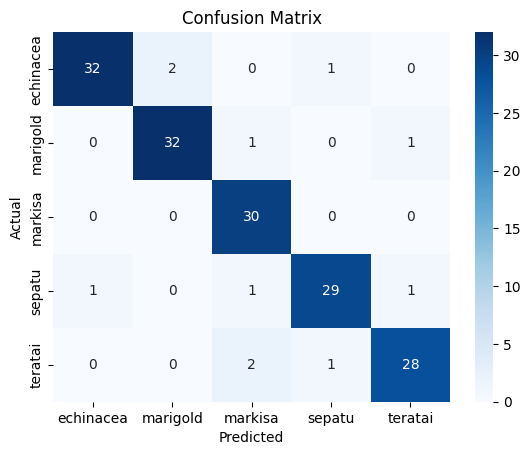

In [ ]:
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=label, yticklabels=label)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=label))

              precision    recall  f1-score   support

   echinacea       0.97      0.91      0.94        35
    marigold       0.94      0.94      0.94        34
     markisa       0.88      1.00      0.94        30
      sepatu       0.94      0.91      0.92        32
     teratai       0.93      0.90      0.92        31

    accuracy                           0.93       162
   macro avg       0.93      0.93      0.93       162
weighted avg       0.93      0.93      0.93       162



**Insight**:
- Kelas `markisa` memiliki presisi terendah, tapi memiliki recall yang sempurna. Ini berarti model lebih menekankan prediksi untuk kelas `markisa` sehingga banyak prediksi untuk kelas tersebut.
- Kelas lainnya memiliki presisi tinggi, tapi memiliki recall yang rendah. Ini berkebalikan dengan kelas `markisa`.

## Setup untuk Submission

### Ubah ke Zip

In [ ]:
import zipfile
import os

In [ ]:
with zipfile.ZipFile('models.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
  for root, _, files in os.walk('models'):
    for file in files:
      file_path = os.path.join(root, file)
      relative_path = os.path.relpath(file_path, 'models')
      zipf.write(file_path, relative_path)

### Buat `requirenments.txt`

In [ ]:
!pip freeze requirenments.txt

absl-py==1.4.0
accelerate==1.5.2
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.5
ale-py==0.10.2
altair==5.5.0
annotated-types==0.7.0
anyio==4.9.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.1
arviz==0.21.0
astropy==7.0.1
astropy-iers-data==0.2025.3.31.0.36.18
asttokens==3.0.0
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
beautifulsoup4==4.13.3
betterproto==2.0.0b6
bigframes==1.42.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.2.1
blosc2==3.2.1
bokeh==3.6.3
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.89
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.21.0
cloudpickle==3.1.1
cmake==3.31.6
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0